In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [ ]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [ ]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

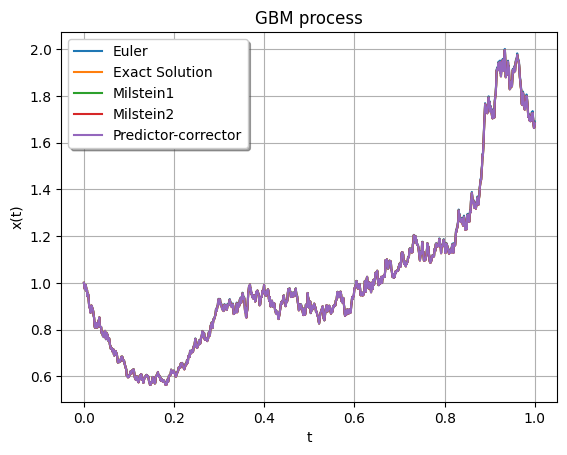

In [ ]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [ ]:
def getMaxAbsoluteDifference(n):
  T = 1
  Nx = 1
  Nt = n

  x0 = 1
  init_state = x0 * np.ones(Nx)

  theta1 = 1
  theta2 = 1/2
  params = [theta1, theta2]

  dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)
  BSMp = BSMprocess(params, T, Nx, Nt, init_state)

  t_exact_data, x_exact_data = BSMp.ExactSolution(dwt)

  t_data, x_data = BSMp.EulerSolution(dwt)
  max_diff_euler = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.Milstein1Solution(dwt)
  max_diff_milstein_1 = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.Milstein2Solution(dwt)
  max_diff_milstein_2 = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
  max_diff_predictor_corrector = np.max(np.abs(x_exact_data - x_data))

  return pd.DataFrame({
        "N": [N],
        "Euler": [max_diff_euler],
        "Milstein1": [max_diff_milstein_1],
        "Milstein2": [max_diff_milstein_2],
        "PredictorCorrector": [max_diff_predictor_corrector]
    })

In [ ]:
# Создаем DataFrame для хранения результатов
results = pd.DataFrame(columns=["N", "Euler", "Milstein1", "PredictorCorrector"])

N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]  # Число шагов

for N in N_values:
  results = pd.concat([results, getMaxAbsoluteDifference(N)], ignore_index=True)

# Округление значений до 5 знаков после запятой для лучшего представления
results = results.round(8)
results

<ipython-input-76-9fa3f520155b>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, getMaxAbsoluteDifference(N)], ignore_index=True)


,N,Euler,Milstein1,PredictorCorrector,Milstein2
0,2,0.327519,0.450456,0.059076,0.015697
1,4,0.105911,0.059315,0.002332,0.009587
2,8,0.103357,0.134791,0.011218,0.007376
3,128,0.022205,0.003340,0.000430,0.000421
4,256,0.030051,0.014785,0.001912,0.000740
5,512,0.018274,0.001621,0.000227,0.000132
6,1024,0.019754,0.000831,0.000145,0.000069
7,8192,0.001937,0.000081,0.000008,0.000007
8,16384,0.007355,0.000169,0.000016,0.000006
9,32768,0.002574,0.000016,0.000003,0.000002


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



In [ ]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Задаем параметры
T = 1.0
Nx = 1  # Число траекторий
Nt = 500  # Количество шагов для дискретизации
N_values = [Nt]  # Используем только одно значение для детализации

# Диапазоны значений для параметров alpha и eta
alpha_values = np.linspace(0, 1, 25)
eta_values = np.linspace(0, 1, 25)

# Создаем массивы для хранения значений отклонений
alpha_eta_diffs = []

# Генерация случайных приращений Винеровского процесса
dwt = np.random.normal(0, np.sqrt(T/Nt), Nt)
# dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

# Создаем объект Wiener процесса
process = StochasticProcess(params=[], T=T, Nx=Nx, Nt=Nt)
t_exact, x_exact = process.ExactSolution(dwt)  # Получаем точное решение

# Исследуем влияние параметров alpha и eta
for alpha in alpha_values:
    for eta in eta_values:
        # Получаем решение методом предиктора-корректора
        t_predictor_corrector, x_predictor_corrector = process.PredictorCorrectorSolution(dwt, eta=eta, alpha=alpha)

        # Считаем максимальное отклонение
        max_diff = np.max(np.abs(x_exact - x_predictor_corrector))

        # Добавляем результат в массив
        alpha_eta_diffs.append([alpha, eta, max_diff])


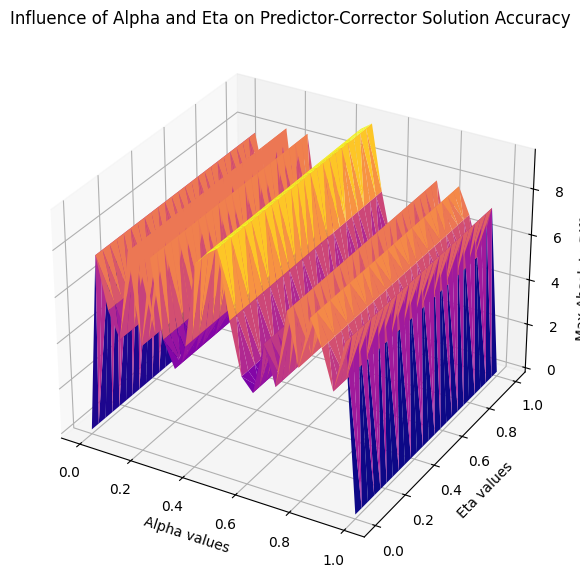

In [ ]:
# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(alpha_eta_diffs, columns=["Alpha", "Eta", "MaxDifference"])

# Построение 3D графика
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# График зависимости максимального отклонения от alpha и eta
ax.plot_trisurf(results_df["Eta"], results_df["Alpha"], results_df["MaxDifference"], cmap='plasma')
ax.set_ylabel("Eta values")
ax.set_xlabel("Alpha values")
ax.set_zlabel("Max Absolute Difference")
ax.set_title("Influence of Alpha and Eta on Predictor-Corrector Solution Accuracy")

plt.show()

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

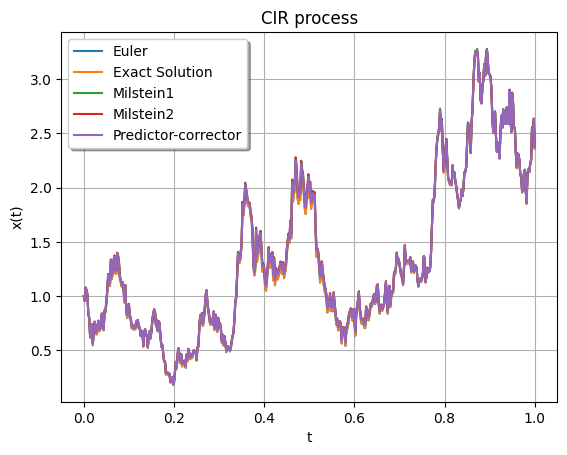

In [ ]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

In [ ]:
def getMaxAbsoluteDifference(n):
  T = 1
  Nx = 1
  Nt = n

  x0 = 1
  init_state = x0 * np.ones(Nx)

  theta1 = 1
  theta2 = 1/2
  params = [theta1, theta2]

  dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)
  BSMp = BSMprocess(params, T, Nx, Nt, init_state)

  t_exact_data, x_exact_data = BSMp.ExactSolution(dwt)

  t_data, x_data = BSMp.EulerSolution(dwt)
  max_diff_euler = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.Milstein1Solution(dwt)
  max_diff_milstein_1 = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.Milstein2Solution(dwt)
  max_diff_milstein_2 = np.max(np.abs(x_exact_data - x_data))

  t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
  max_diff_predictor_corrector = np.max(np.abs(x_exact_data - x_data))

  return pd.DataFrame({
        "N": [N],
        "Euler": [max_diff_euler],
        "Milstein1": [max_diff_milstein_1],
        "Milstein2": [max_diff_milstein_2],
        "PredictorCorrector": [max_diff_predictor_corrector]
    })

In [ ]:
# Создаем DataFrame для хранения результатов
results = pd.DataFrame(columns=["N", "Euler", "Milstein1", "Milstein2", "PredictorCorrector"])

N_values = [2, 64, 128, 256, 512, 1024, 8192, 16384, 32768]  # Число шагов

for N in N_values:
  results = pd.concat([results, getMaxAbsoluteDifference(N)], ignore_index=True)

results["N"] = np.log(pd.to_numeric(results["N"], errors='coerce'))

<ipython-input-28-2984eeb3dfd2>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, getMaxAbsoluteDifference(N)], ignore_index=True)


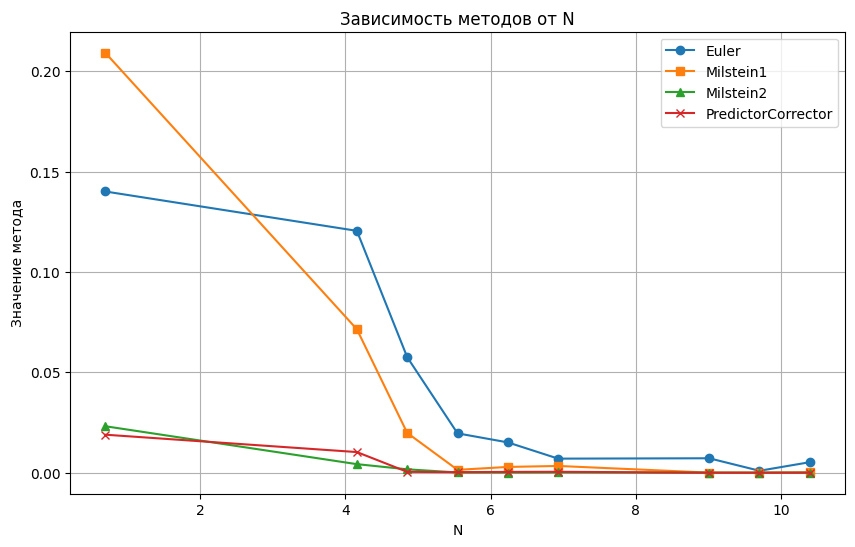

In [ ]:
import matplotlib.pyplot as plt

# Построим график
plt.figure(figsize=(10, 6))
df = results

# Построение графиков для каждого метода
plt.plot(df['N'], df['Euler'], label='Euler', marker='o')
plt.plot(df['N'], df['Milstein1'], label='Milstein1', marker='s')
plt.plot(df['N'], df['Milstein2'], label='Milstein2', marker='^')
plt.plot(df['N'], df['PredictorCorrector'], label='PredictorCorrector', marker='x')

# Настройка графика
plt.xlabel('N')
plt.ylabel('Значение метода')
plt.title('Зависимость методов от N')
plt.legend()
plt.grid(True)

# Показать график
plt.show()


Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [ ]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

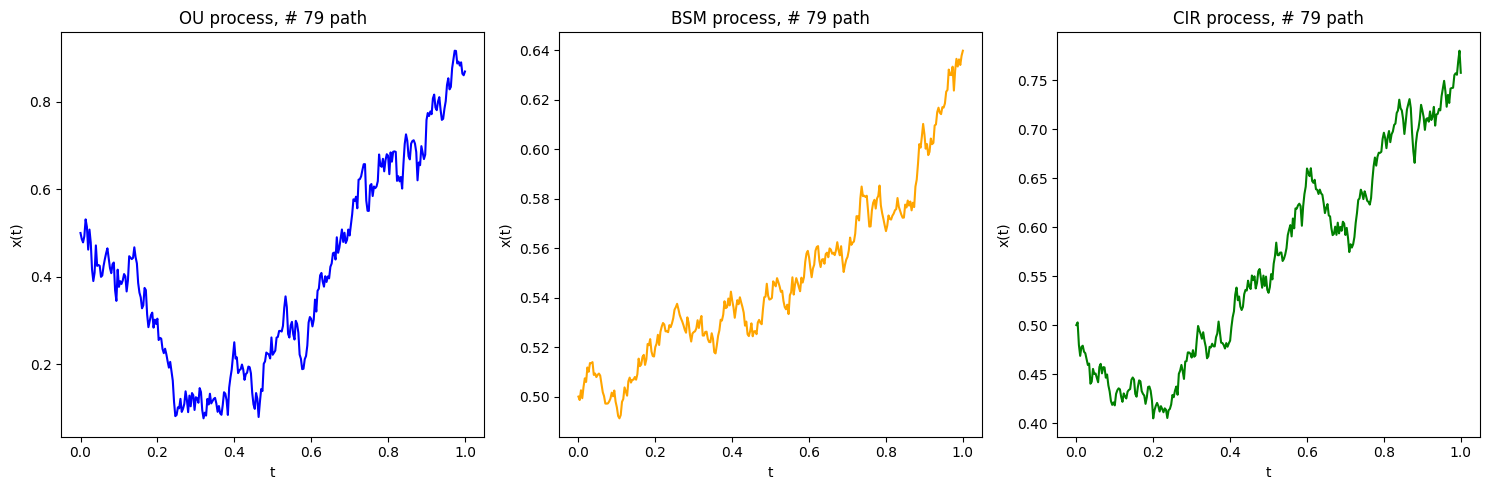

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
3.   Nonlinear mean reversion Ait-Sahalia model;
4.   Jacobi diffusion process;
5.   Ahn and Gao (inverse of Feller’s square root) model;
6.   Radial Ornstein-Uhlenbeck process.

In [ ]:
import numpy as np

class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.theta = params[0]
        self.mu = params[1]
        self.sigma = params[2]

        # Define drift and volatility for Radial Ornstein-Uhlenbeck process
        self.bxt = lambda x: self.theta * (self.mu - x) / np.maximum(x, 1e-5)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def DefaultInitState(self):
        # Initial state defaults to provided init_state or mu if not specified
        return np.full(self.Nx, self.mu) if self.init_state is None else self.init_state

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        # Generate paths using Euler-Maruyama method
        for i in range(1, self.Nt + 1):
            drift = self.bxt(x_data[i - 1]) * dt
            diffusion = self.sigmaxt(x_data[i - 1]) * np.sqrt(dt) * np.random.normal(size=self.Nx)
            x_data[i] = np.maximum(x_data[i - 1] + drift + diffusion, 0)  # Ensure non-negativity for the process

        return t_data, x_data


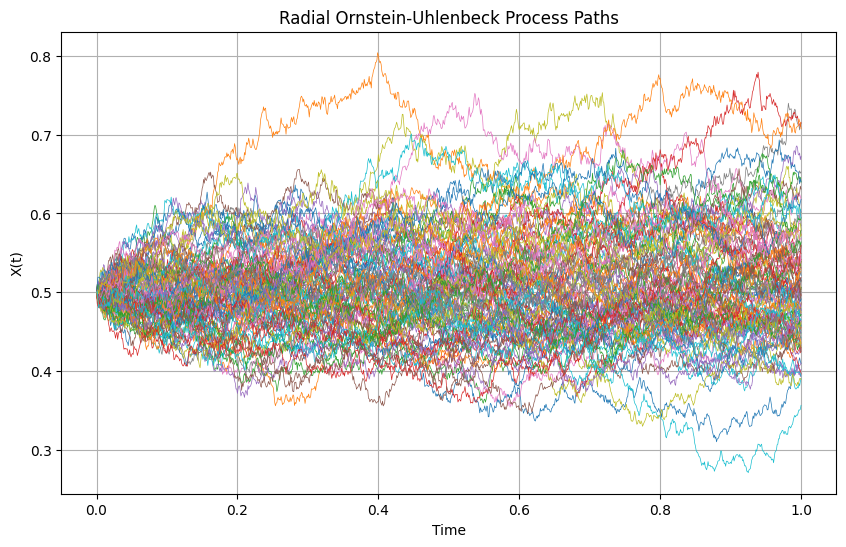

In [ ]:
# Parameters for the Radial Ornstein-Uhlenbeck process
params = [1.0, 0.5, 0.2]  # theta, mu, sigma
T = 1.0   # Total time
Nx = 100  # Number of paths
Nt = 1000 # Number of time steps
init_state = np.full(Nx, 0.5)  # Initial state X_0 = 0.5 for each path

# Initialize Radial Ornstein-Uhlenbeck process
radial_ou_process = RadialOUProcess(params, T, Nx, Nt, init_state)

# Generate paths
t_data, x_data = radial_ou_process.PathGenerator()

# Plotting the generated paths
plt.figure(figsize=(10, 6))
for i in range(Nx):
    plt.plot(t_data, x_data[:, i], lw=0.5)
plt.title("Radial Ornstein-Uhlenbeck Process Paths")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True)
plt.show()


Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

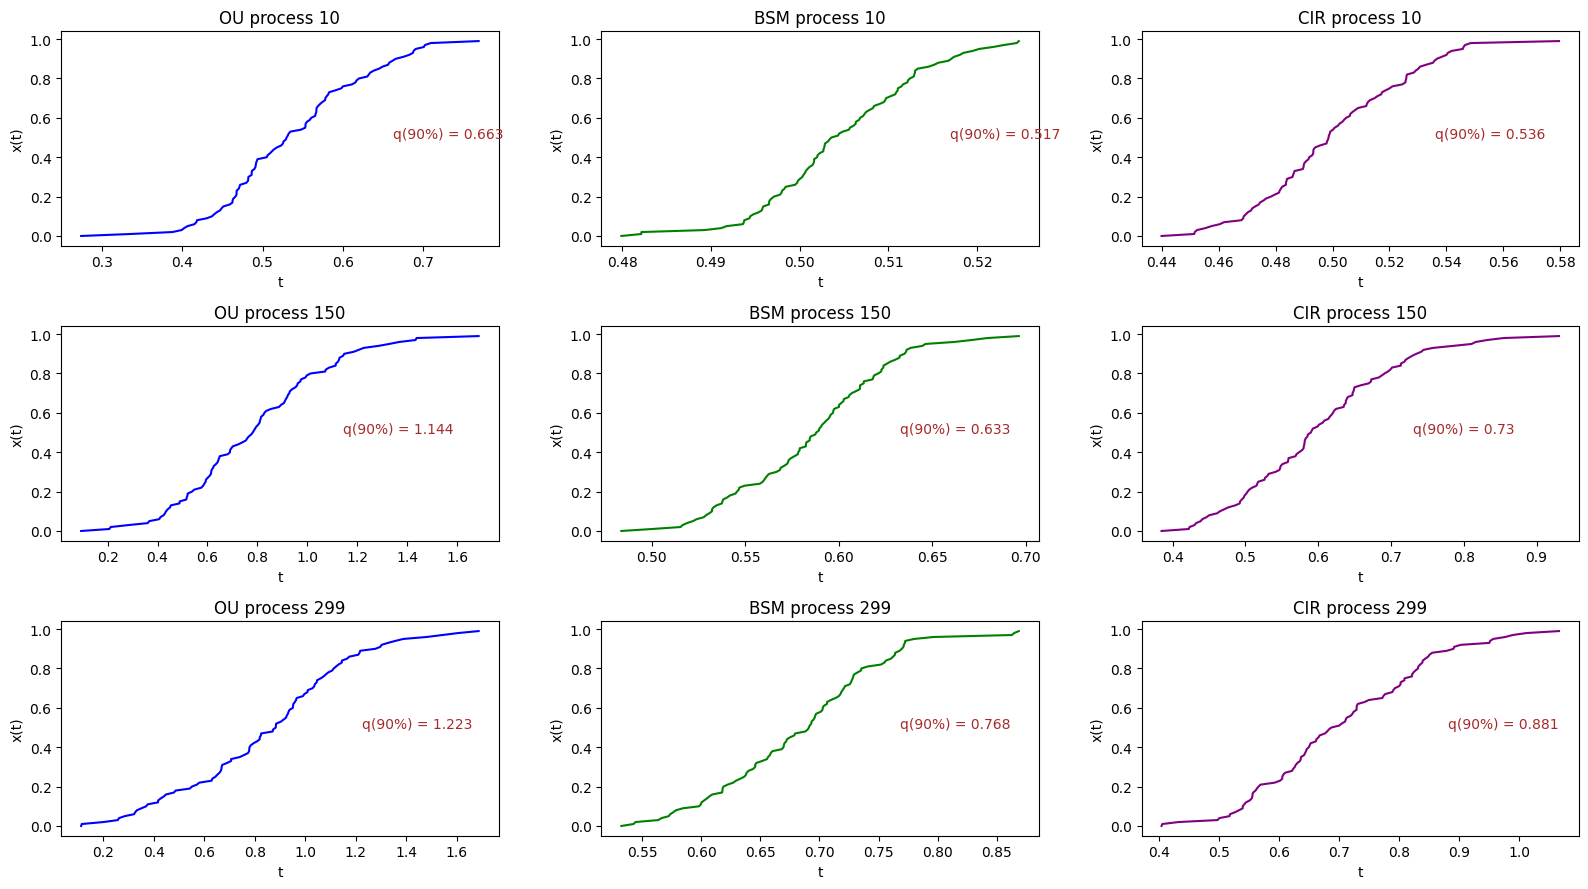

In [ ]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

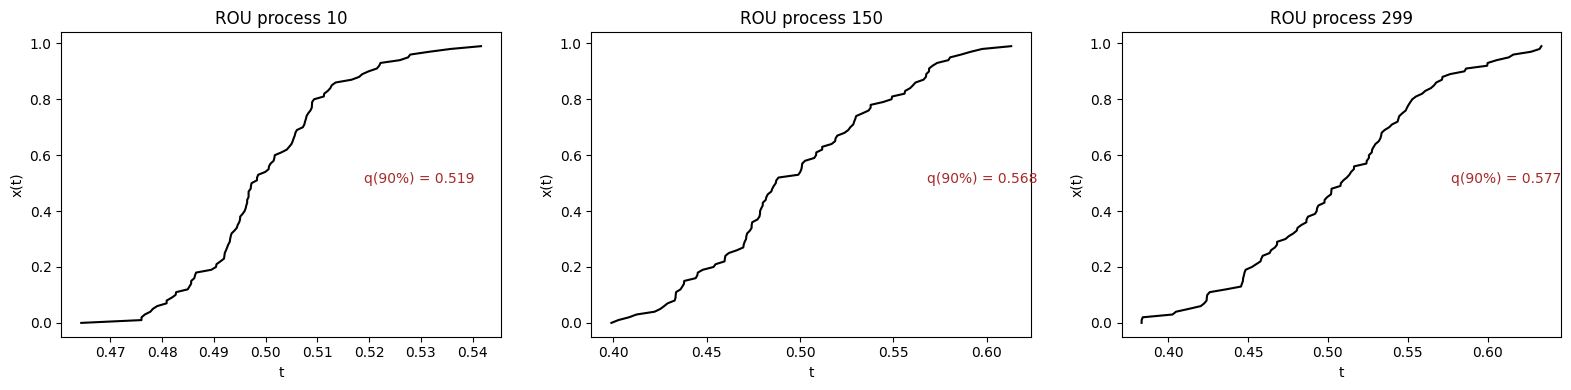

In [ ]:
t_data, x_data_ROU = radial_ou_process.PathGenerator()

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

n = 10
Nx = 100
Nt = 300

T = 1
axs[0].plot(*ecdf(x_data_ROU[n]), color='black')
axs[0].set_title(f'ROU process {n}')
val = round(np.quantile(x_data_ROU[n], 0.9),3)
axs[0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1].plot(*ecdf(x_data_ROU[n]), color='black')
axs[1].set_title(f'ROU process {n}')
val = round(np.quantile(x_data_ROU[n], 0.9),3)
axs[1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2].plot(*ecdf(x_data_ROU[n]), color='black')
axs[2].set_title(f'ROU process {n}')
val = round(np.quantile(x_data_ROU[n], 0.9),3)
axs[2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k].set_xlabel('t')
        axs[k].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

Kolmogorov-Smirnov Test Statistic: 0.12
P-value: 0.469506448503778
Conclusion: Fail to reject the null hypothesis (samples may be from the same distribution)


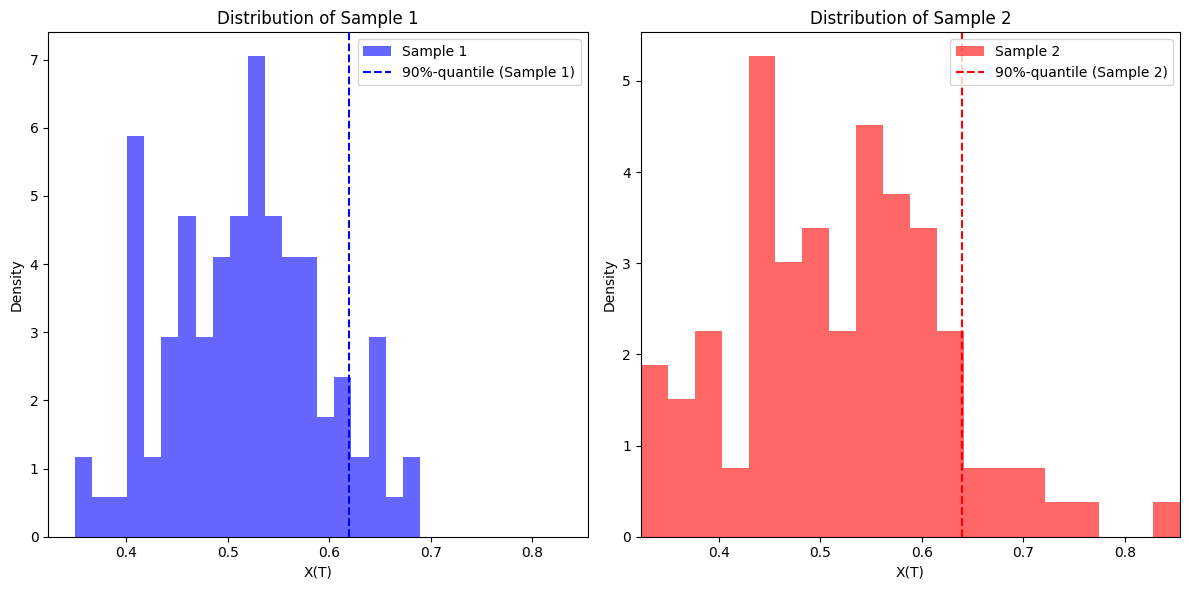

In [ ]:
from scipy.stats import ks_2samp, norm
import numpy as np
import matplotlib.pyplot as plt

# Generate two sample distributions for testing
# Sample 1: Radial OU process
params1 = [1.0, 0.5, 0.2]
T = 1.0
Nx = 100
Nt = 1000
init_state1 = np.full(Nx, 0.5)

radial_ou_process1 = RadialOUProcess(params1, T, Nx, Nt, init_state1)
t_data, x_data1 = radial_ou_process1.PathGenerator()

# Take the final state as the sample for the first process
sample1 = x_data1[-1]

# Sample 2: Another Radial OU process with slightly different parameters
params2 = [0.8, 0.5, 0.25]
init_state2 = np.full(Nx, 0.5)

radial_ou_process2 = RadialOUProcess(params2, T, Nx, Nt, init_state2)
_, x_data2 = radial_ou_process2.PathGenerator()

# Take the final state as the sample for the second process
sample2 = x_data2[-1]

# Perform the Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(sample1, sample2)

# Print the results
print("Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("P-value:", p_value)
if p_value < 0.05:
    conclusion = "Reject the null hypothesis (samples are from different distributions)"
else:
    conclusion = "Fail to reject the null hypothesis (samples may be from the same distribution)"
print("Conclusion:", conclusion)

# Plotting the two distributions with 90%-quantile vertical lines
plt.figure(figsize=(12, 6))

# Plot sample 1
plt.subplot(1, 2, 1)
plt.hist(sample1, bins=20, alpha=0.6, color='blue', density=True, label="Sample 1")
q90_sample1 = np.quantile(sample1, 0.9)
plt.axvline(q90_sample1, color='blue', linestyle='--', label="90%-quantile (Sample 1)")
plt.title("Distribution of Sample 1")
plt.xlabel("X(T)")
plt.ylabel("Density")
plt.legend()

# Plot sample 2
plt.subplot(1, 2, 2)
plt.hist(sample2, bins=20, alpha=0.6, color='red', density=True, label="Sample 2")
q90_sample2 = np.quantile(sample2, 0.9)
plt.axvline(q90_sample2, color='red', linestyle='--', label="90%-quantile (Sample 2)")
plt.title("Distribution of Sample 2")
plt.xlabel("X(T)")
plt.ylabel("Density")
plt.legend()

# Set the same X-axis range for both plots
plt.subplot(1, 2, 1).set_xlim(min(min(sample1), min(sample2)), max(max(sample1), max(sample2)))
plt.subplot(1, 2, 2).set_xlim(min(min(sample1), min(sample2)), max(max(sample1), max(sample2)))

plt.tight_layout()
plt.show()


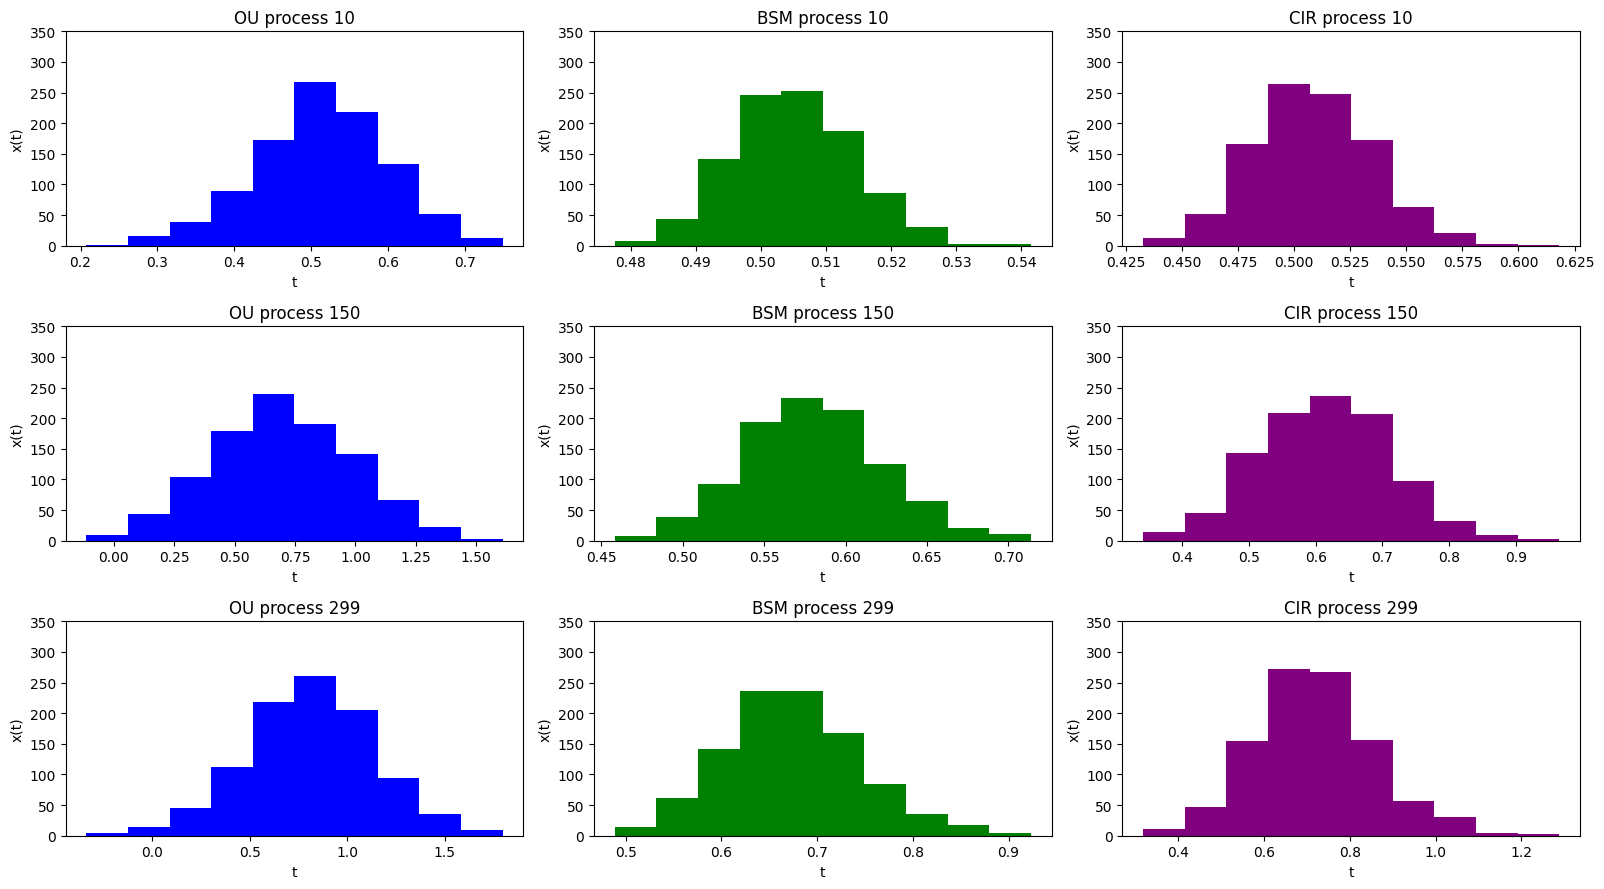

In [ ]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

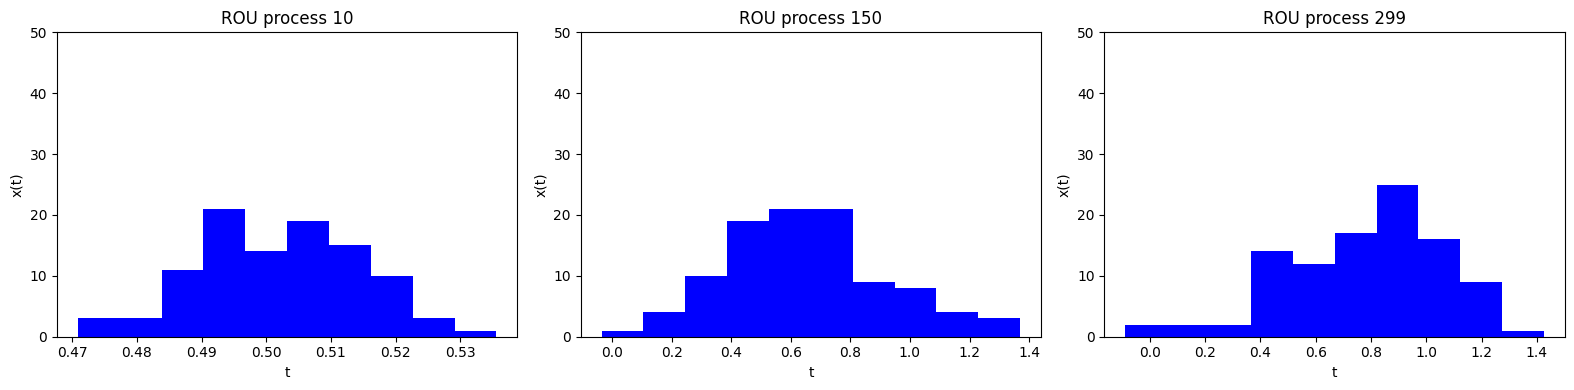

In [ ]:
#density function
t_data, x_data_ROU = radial_ou_process.PathGenerator()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

n = 10

axs[0].hist(x_data_ROU[n], color='blue')
axs[0].set_title(f'ROU process {n}')

n = Nt // 2
axs[1].hist(x_data_OU[n], color='blue')
axs[1].set_title(f'ROU process {n}')

n = Nt - 1
axs[2].hist(x_data_OU[n], color='blue')
axs[2].set_title(f'ROU process {n}')

for k in range(0, 3):
      axs[k].set_ylim(0, 50)
      #axs[k][j].set_xlim(0, 2)
      axs[k].set_xlabel('t')
      axs[k].set_ylabel('x(t)')

plt.tight_layout()

plt.show()